# sw4lite

## Parameters
make ckernel=yes debug=no openmp=yes  
Compiler = 'gcc'  
Build_Flags = '-g -O3'  
Run_Parameters = 'loh1/LOH.1-h100.in'  

## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

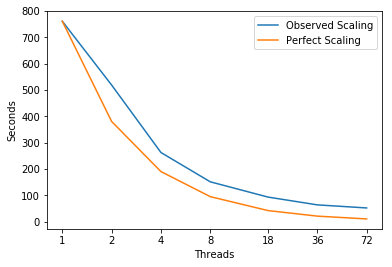

In [15]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# JobID 37741
scaling=[ 760.87002 , 518.76499 , 262.5649925 , 151.3849925 , 93.4533333333 , 63.8736141667 , 52.1833315278 , ]
ax.plot(Threads,scaling,
        label='Observed Scaling')
perfect_scaling=[scaling[0]/t for t in Threads]
ax.plot(Threads, perfect_scaling,
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()


## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME (seconds)| Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used | JobId
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
|1|695|1.0|0.021%|0.31%|0.29%|0.87|0.0041%|0.0017%|0.0047%|37776|
|72|43.7|0.65|0.027%|0.51%|0.3%|0.39|0.083%|0.059%|0.17%|37783|


---
## evalRHS

```c
void EW::evalRHS(vector<Sarray> & a_U, vector<Sarray>& a_Mu, vector<Sarray>& a_Lambda,
		 vector<Sarray> & a_Uacc )
{
   for(int g=0 ; g<mNumberOfCartesianGrids; g++ )
   {
#ifdef SW4_CROUTINES
      if( m_corder )
	 rhs4sg_rev( m_iStart[g], m_iEnd[g], m_jStart[g], m_jEnd[g], 
		     m_kStart[g], m_kEnd[g], m_global_nz[g], m_onesided[g],
		     m_acof, m_bope, m_ghcof, a_Uacc[g].c_ptr(), a_U[g].c_ptr(), 
		     a_Mu[g].c_ptr(), a_Lambda[g].c_ptr(), mGridSize[g],
		     m_sg_str_x[g], m_sg_str_y[g], m_sg_str_z[g] );

```
| loop at EW.c: 3074 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used | JobID |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
|1|81.6%|1.1|0.015%|0.36%|0.35%|0.87|0.0029%|0.0014%|0.0047%|37776|
|72|37.2%|1.3|0.022%|0.53%|0.3%|0.83|0.15%|0.11%|0.3%|37783|


```c
void rhs4sg_rev( int ifirst, int ilast, int jfirst, int jlast, int kfirst, int klast,
		 int nk, int* __restrict__ onesided, float_sw4* __restrict__ a_acof, float_sw4 *__restrict__ a_bope,
		 float_sw4* __restrict__ a_ghcof, float_sw4* __restrict__ a_lu, float_sw4* __restrict__ a_u,
		 float_sw4* __restrict__ a_mu, float_sw4* __restrict__ a_lambda, 
		 float_sw4 h, float_sw4* __restrict__ a_strx, float_sw4* __restrict__ a_stry, 
		 float_sw4* __restrict__ a_strz )
{
   // This would work to create multi-dimensional C arrays:
   //   float_sw4** b_ar=(float_sw4*)malloc(ni*nj*sizeof(float_sw4*));
   //   for( int j=0;j<nj;j++)
   //      b_ar[j] = &a_lu[j-1+ni*(1-1)];
   //#define ar(i,j) b_ar[j][i];

 // Direct reuse of fortran code by these macro definitions:
#define mu(i,j,k)     a_mu[base+i+ni*(j)+nij*(k)]
#define la(i,j,k) a_lambda[base+i+ni*(j)+nij*(k)]
   // Reversed indexation
#define u(c,i,j,k)   a_u[base3+i+ni*(j)+nij*(k)+nijk*(c)]   
#define lu(c,i,j,k) a_lu[base3+i+ni*(j)+nij*(k)+nijk*(c)]   
#define strx(i) a_strx[i-ifirst0]
#define stry(j) a_stry[j-jfirst0]
#define strz(k) a_strz[k-kfirst0]
#define acof(i,j,k) a_acof[(i-1)+6*(j-1)+48*(k-1)]
#define bope(i,j) a_bope[i-1+6*(j-1)]
#define ghcof(i) a_ghcof[i-1]
   
   const float_sw4 a1   = 0;
   const float_sw4 i6   = 1.0/6;
   const float_sw4 i12  = 1.0/12;
   const float_sw4 i144 = 1.0/144;
   const float_sw4 tf   = 0.75;

   const int ni    = ilast-ifirst+1;
   const int nij   = ni*(jlast-jfirst+1);
   const int nijk  = nij*(klast-kfirst+1);
   const int base  = -(ifirst+ni*jfirst+nij*kfirst);
   const int base3 = base-nijk;
   const int nic  = 3*ni;
   const int nijc = 3*nij;
   const int ifirst0 = ifirst;
   const int jfirst0 = jfirst;
   const int kfirst0 = kfirst;

   int k1, k2, kb;
   int i, j, k, q, m, qb, mb;
   float_sw4 mux1, mux2, mux3, mux4, muy1, muy2, muy3, muy4, muz1, muz2, muz3, muz4;
   float_sw4 r1, r2, r3, mucof, mu1zz, mu2zz, mu3zz;
   float_sw4 lap2mu, u3zip2, u3zip1, u3zim1, u3zim2, lau3zx, mu3xz, u3zjp2, u3zjp1, u3zjm1, u3zjm2;
   float_sw4 lau3zy, mu3yz, mu1zx, mu2zy, u1zip2, u1zip1, u1zim1, u1zim2;
   float_sw4 u2zjp2, u2zjp1, u2zjm1, u2zjm2, lau1xz, lau2yz;

   const float_sw4 cof = 1.0/(h*h);


   k1 = kfirst+2;
   if( onesided[4] == 1 )
      k1 = 7;
   k2 = klast-2;
   if( onesided[5] == 1 )
      k2 = nk-6;
   
#pragma omp parallel private(k,i,j,mux1,mux2,mux3,mux4,muy1,muy2,muy3,muy4,\
              r1,r2,r3,mucof,mu1zz,mu2zz,mu3zz,lap2mu,q,u3zip2,u3zip1,\
              u3zim1,u3zim2,lau3zx,mu3xz,u3zjp2,u3zjp1,u3zjm1,u3zjm2,lau3zy,\
              mu3yz,mu1zx,u1zip2,u1zip1,u1zim1,u1zim2,\
	      u2zjp2,u2zjp1,u2zjm1,u2zjm2,mu2zy,lau1xz,lau2yz,kb,qb,mb,muz1,muz2,muz3,muz4)
   {
#pragma omp for
   for( k= k1; k <= k2 ; k++ )
      for( j=jfirst+2; j <= jlast-2 ; j++ )
#pragma simd
#pragma ivdep
	 for( i=ifirst+2; i <= ilast-2 ; i++ )
	 {

/* from inner_loop_4a, 28x3 = 84 ops */
            mux1 = mu(i-1,j,k)*strx(i-1)-
	       tf*(mu(i,j,k)*strx(i)+mu(i-2,j,k)*strx(i-2));
            mux2 = mu(i-2,j,k)*strx(i-2)+mu(i+1,j,k)*strx(i+1)+
	       3*(mu(i,j,k)*strx(i)+mu(i-1,j,k)*strx(i-1));
            mux3 = mu(i-1,j,k)*strx(i-1)+mu(i+2,j,k)*strx(i+2)+
	       3*(mu(i+1,j,k)*strx(i+1)+mu(i,j,k)*strx(i));
            mux4 = mu(i+1,j,k)*strx(i+1)-
	       tf*(mu(i,j,k)*strx(i)+mu(i+2,j,k)*strx(i+2));

            muy1 = mu(i,j-1,k)*stry(j-1)-
	       tf*(mu(i,j,k)*stry(j)+mu(i,j-2,k)*stry(j-2));
            muy2 = mu(i,j-2,k)*stry(j-2)+mu(i,j+1,k)*stry(j+1)+
	       3*(mu(i,j,k)*stry(j)+mu(i,j-1,k)*stry(j-1));
            muy3 = mu(i,j-1,k)*stry(j-1)+mu(i,j+2,k)*stry(j+2)+
	       3*(mu(i,j+1,k)*stry(j+1)+mu(i,j,k)*stry(j));
            muy4 = mu(i,j+1,k)*stry(j+1)-
	       tf*(mu(i,j,k)*stry(j)+mu(i,j+2,k)*stry(j+2));

            muz1 = mu(i,j,k-1)*strz(k-1)-
	       tf*(mu(i,j,k)*strz(k)+mu(i,j,k-2)*strz(k-2));
            muz2 = mu(i,j,k-2)*strz(k-2)+mu(i,j,k+1)*strz(k+1)+
	       3*(mu(i,j,k)*strz(k)+mu(i,j,k-1)*strz(k-1));
            muz3 = mu(i,j,k-1)*strz(k-1)+mu(i,j,k+2)*strz(k+2)+
	       3*(mu(i,j,k+1)*strz(k+1)+mu(i,j,k)*strz(k));
            muz4 = mu(i,j,k+1)*strz(k+1)-
	       tf*(mu(i,j,k)*strz(k)+mu(i,j,k+2)*strz(k+2));
/* xx, yy, and zz derivatives:*/
/* 75 ops */
            r1 = i6*( strx(i)*( (2*mux1+la(i-1,j,k)*strx(i-1)-
               tf*(la(i,j,k)*strx(i)+la(i-2,j,k)*strx(i-2)))*
                              (u(1,i-2,j,k)-u(1,i,j,k))+
           (2*mux2+la(i-2,j,k)*strx(i-2)+la(i+1,j,k)*strx(i+1)+
                3*(la(i,j,k)*strx(i)+la(i-1,j,k)*strx(i-1)))*
                              (u(1,i-1,j,k)-u(1,i,j,k))+ 
           (2*mux3+la(i-1,j,k)*strx(i-1)+la(i+2,j,k)*strx(i+2)+
                3*(la(i+1,j,k)*strx(i+1)+la(i,j,k)*strx(i)))*
                              (u(1,i+1,j,k)-u(1,i,j,k))+
                (2*mux4+ la(i+1,j,k)*strx(i+1)-
               tf*(la(i,j,k)*strx(i)+la(i+2,j,k)*strx(i+2)))*
                (u(1,i+2,j,k)-u(1,i,j,k)) ) + stry(j)*(
                     muy1*(u(1,i,j-2,k)-u(1,i,j,k)) + 
                     muy2*(u(1,i,j-1,k)-u(1,i,j,k)) + 
                     muy3*(u(1,i,j+1,k)-u(1,i,j,k)) +
                     muy4*(u(1,i,j+2,k)-u(1,i,j,k)) ) + strz(k)*(
                     muz1*(u(1,i,j,k-2)-u(1,i,j,k)) + 
                     muz2*(u(1,i,j,k-1)-u(1,i,j,k)) + 
                     muz3*(u(1,i,j,k+1)-u(1,i,j,k)) +
                     muz4*(u(1,i,j,k+2)-u(1,i,j,k)) ) );

/* 75 ops */
            r2 = i6*( strx(i)*(mux1*(u(2,i-2,j,k)-u(2,i,j,k)) + 
                      mux2*(u(2,i-1,j,k)-u(2,i,j,k)) + 
                      mux3*(u(2,i+1,j,k)-u(2,i,j,k)) +
                      mux4*(u(2,i+2,j,k)-u(2,i,j,k)) ) + stry(j)*(
                  (2*muy1+la(i,j-1,k)*stry(j-1)-
                      tf*(la(i,j,k)*stry(j)+la(i,j-2,k)*stry(j-2)))*
                          (u(2,i,j-2,k)-u(2,i,j,k))+
           (2*muy2+la(i,j-2,k)*stry(j-2)+la(i,j+1,k)*stry(j+1)+
                     3*(la(i,j,k)*stry(j)+la(i,j-1,k)*stry(j-1)))*
                          (u(2,i,j-1,k)-u(2,i,j,k))+ 
           (2*muy3+la(i,j-1,k)*stry(j-1)+la(i,j+2,k)*stry(j+2)+
                     3*(la(i,j+1,k)*stry(j+1)+la(i,j,k)*stry(j)))*
                          (u(2,i,j+1,k)-u(2,i,j,k))+
                  (2*muy4+la(i,j+1,k)*stry(j+1)-
                    tf*(la(i,j,k)*stry(j)+la(i,j+2,k)*stry(j+2)))*
                          (u(2,i,j+2,k)-u(2,i,j,k)) ) + strz(k)*(
                     muz1*(u(2,i,j,k-2)-u(2,i,j,k)) + 
                     muz2*(u(2,i,j,k-1)-u(2,i,j,k)) + 
                     muz3*(u(2,i,j,k+1)-u(2,i,j,k)) +
                     muz4*(u(2,i,j,k+2)-u(2,i,j,k)) ) );

/* 75 ops */
            r3 = i6*( strx(i)*(mux1*(u(3,i-2,j,k)-u(3,i,j,k)) + 
                      mux2*(u(3,i-1,j,k)-u(3,i,j,k)) + 
                      mux3*(u(3,i+1,j,k)-u(3,i,j,k)) +
                      mux4*(u(3,i+2,j,k)-u(3,i,j,k))  ) + stry(j)*(
                     muy1*(u(3,i,j-2,k)-u(3,i,j,k)) + 
                     muy2*(u(3,i,j-1,k)-u(3,i,j,k)) + 
                     muy3*(u(3,i,j+1,k)-u(3,i,j,k)) +
                     muy4*(u(3,i,j+2,k)-u(3,i,j,k)) ) + strz(k)*(
                  (2*muz1+la(i,j,k-1)*strz(k-1)-
                      tf*(la(i,j,k)*strz(k)+la(i,j,k-2)*strz(k-2)))*
                          (u(3,i,j,k-2)-u(3,i,j,k))+
           (2*muz2+la(i,j,k-2)*strz(k-2)+la(i,j,k+1)*strz(k+1)+
                      3*(la(i,j,k)*strz(k)+la(i,j,k-1)*strz(k-1)))*
                          (u(3,i,j,k-1)-u(3,i,j,k))+ 
           (2*muz3+la(i,j,k-1)*strz(k-1)+la(i,j,k+2)*strz(k+2)+
                      3*(la(i,j,k+1)*strz(k+1)+la(i,j,k)*strz(k)))*
                          (u(3,i,j,k+1)-u(3,i,j,k))+
                  (2*muz4+la(i,j,k+1)*strz(k+1)-
                    tf*(la(i,j,k)*strz(k)+la(i,j,k+2)*strz(k+2)))*
		  (u(3,i,j,k+2)-u(3,i,j,k)) ) );


/* Mixed derivatives: */
/* 29ops /mixed derivative */
/* 116 ops for r1 */
/*   (la*v_y)_x */
            r1 = r1 + strx(i)*stry(j)*
                 i144*( la(i-2,j,k)*(u(2,i-2,j-2,k)-u(2,i-2,j+2,k)+
                             8*(-u(2,i-2,j-1,k)+u(2,i-2,j+1,k))) - 8*(
                        la(i-1,j,k)*(u(2,i-1,j-2,k)-u(2,i-1,j+2,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i-1,j+1,k))) )+8*(
                        la(i+1,j,k)*(u(2,i+1,j-2,k)-u(2,i+1,j+2,k)+
                             8*(-u(2,i+1,j-1,k)+u(2,i+1,j+1,k))) ) - (
                        la(i+2,j,k)*(u(2,i+2,j-2,k)-u(2,i+2,j+2,k)+
                             8*(-u(2,i+2,j-1,k)+u(2,i+2,j+1,k))) )) 
/*   (la*w_z)_x */
               + strx(i)*strz(k)*       
                 i144*( la(i-2,j,k)*(u(3,i-2,j,k-2)-u(3,i-2,j,k+2)+
                             8*(-u(3,i-2,j,k-1)+u(3,i-2,j,k+1))) - 8*(
                        la(i-1,j,k)*(u(3,i-1,j,k-2)-u(3,i-1,j,k+2)+
                             8*(-u(3,i-1,j,k-1)+u(3,i-1,j,k+1))) )+8*(
                        la(i+1,j,k)*(u(3,i+1,j,k-2)-u(3,i+1,j,k+2)+
                             8*(-u(3,i+1,j,k-1)+u(3,i+1,j,k+1))) ) - (
                        la(i+2,j,k)*(u(3,i+2,j,k-2)-u(3,i+2,j,k+2)+
                             8*(-u(3,i+2,j,k-1)+u(3,i+2,j,k+1))) )) 
/*   (mu*v_x)_y */
               + strx(i)*stry(j)*       
                 i144*( mu(i,j-2,k)*(u(2,i-2,j-2,k)-u(2,i+2,j-2,k)+
                             8*(-u(2,i-1,j-2,k)+u(2,i+1,j-2,k))) - 8*(
                        mu(i,j-1,k)*(u(2,i-2,j-1,k)-u(2,i+2,j-1,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i+1,j-1,k))) )+8*(
                        mu(i,j+1,k)*(u(2,i-2,j+1,k)-u(2,i+2,j+1,k)+
                             8*(-u(2,i-1,j+1,k)+u(2,i+1,j+1,k))) ) - (
                        mu(i,j+2,k)*(u(2,i-2,j+2,k)-u(2,i+2,j+2,k)+
                             8*(-u(2,i-1,j+2,k)+u(2,i+1,j+2,k))) )) 
/*   (mu*w_x)_z */
               + strx(i)*strz(k)*       
                 i144*( mu(i,j,k-2)*(u(3,i-2,j,k-2)-u(3,i+2,j,k-2)+
                             8*(-u(3,i-1,j,k-2)+u(3,i+1,j,k-2))) - 8*(
                        mu(i,j,k-1)*(u(3,i-2,j,k-1)-u(3,i+2,j,k-1)+
                             8*(-u(3,i-1,j,k-1)+u(3,i+1,j,k-1))) )+8*(
                        mu(i,j,k+1)*(u(3,i-2,j,k+1)-u(3,i+2,j,k+1)+
                             8*(-u(3,i-1,j,k+1)+u(3,i+1,j,k+1))) ) - (
                        mu(i,j,k+2)*(u(3,i-2,j,k+2)-u(3,i+2,j,k+2)+
				     8*(-u(3,i-1,j,k+2)+u(3,i+1,j,k+2))) )) ;

/* 116 ops for r2 */
/*   (mu*u_y)_x */
            r2 = r2 + strx(i)*stry(j)*
                 i144*( mu(i-2,j,k)*(u(1,i-2,j-2,k)-u(1,i-2,j+2,k)+
                             8*(-u(1,i-2,j-1,k)+u(1,i-2,j+1,k))) - 8*(
                        mu(i-1,j,k)*(u(1,i-1,j-2,k)-u(1,i-1,j+2,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i-1,j+1,k))) )+8*(
                        mu(i+1,j,k)*(u(1,i+1,j-2,k)-u(1,i+1,j+2,k)+
                             8*(-u(1,i+1,j-1,k)+u(1,i+1,j+1,k))) ) - (
                        mu(i+2,j,k)*(u(1,i+2,j-2,k)-u(1,i+2,j+2,k)+
                             8*(-u(1,i+2,j-1,k)+u(1,i+2,j+1,k))) )) 
/* (la*u_x)_y */
              + strx(i)*stry(j)*
                 i144*( la(i,j-2,k)*(u(1,i-2,j-2,k)-u(1,i+2,j-2,k)+
                             8*(-u(1,i-1,j-2,k)+u(1,i+1,j-2,k))) - 8*(
                        la(i,j-1,k)*(u(1,i-2,j-1,k)-u(1,i+2,j-1,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i+1,j-1,k))) )+8*(
                        la(i,j+1,k)*(u(1,i-2,j+1,k)-u(1,i+2,j+1,k)+
                             8*(-u(1,i-1,j+1,k)+u(1,i+1,j+1,k))) ) - (
                        la(i,j+2,k)*(u(1,i-2,j+2,k)-u(1,i+2,j+2,k)+
                             8*(-u(1,i-1,j+2,k)+u(1,i+1,j+2,k))) )) 
/* (la*w_z)_y */
               + stry(j)*strz(k)*
                 i144*( la(i,j-2,k)*(u(3,i,j-2,k-2)-u(3,i,j-2,k+2)+
                             8*(-u(3,i,j-2,k-1)+u(3,i,j-2,k+1))) - 8*(
                        la(i,j-1,k)*(u(3,i,j-1,k-2)-u(3,i,j-1,k+2)+
                             8*(-u(3,i,j-1,k-1)+u(3,i,j-1,k+1))) )+8*(
                        la(i,j+1,k)*(u(3,i,j+1,k-2)-u(3,i,j+1,k+2)+
                             8*(-u(3,i,j+1,k-1)+u(3,i,j+1,k+1))) ) - (
                        la(i,j+2,k)*(u(3,i,j+2,k-2)-u(3,i,j+2,k+2)+
                             8*(-u(3,i,j+2,k-1)+u(3,i,j+2,k+1))) ))
/* (mu*w_y)_z */
               + stry(j)*strz(k)*
                 i144*( mu(i,j,k-2)*(u(3,i,j-2,k-2)-u(3,i,j+2,k-2)+
                             8*(-u(3,i,j-1,k-2)+u(3,i,j+1,k-2))) - 8*(
                        mu(i,j,k-1)*(u(3,i,j-2,k-1)-u(3,i,j+2,k-1)+
                             8*(-u(3,i,j-1,k-1)+u(3,i,j+1,k-1))) )+8*(
                        mu(i,j,k+1)*(u(3,i,j-2,k+1)-u(3,i,j+2,k+1)+
                             8*(-u(3,i,j-1,k+1)+u(3,i,j+1,k+1))) ) - (
                        mu(i,j,k+2)*(u(3,i,j-2,k+2)-u(3,i,j+2,k+2)+
				     8*(-u(3,i,j-1,k+2)+u(3,i,j+1,k+2))) )) ;
/* 116 ops for r3 */
/*  (mu*u_z)_x */
            r3 = r3 + strx(i)*strz(k)*
                 i144*( mu(i-2,j,k)*(u(1,i-2,j,k-2)-u(1,i-2,j,k+2)+
                             8*(-u(1,i-2,j,k-1)+u(1,i-2,j,k+1))) - 8*(
                        mu(i-1,j,k)*(u(1,i-1,j,k-2)-u(1,i-1,j,k+2)+
                             8*(-u(1,i-1,j,k-1)+u(1,i-1,j,k+1))) )+8*(
                        mu(i+1,j,k)*(u(1,i+1,j,k-2)-u(1,i+1,j,k+2)+
                             8*(-u(1,i+1,j,k-1)+u(1,i+1,j,k+1))) ) - (
                        mu(i+2,j,k)*(u(1,i+2,j,k-2)-u(1,i+2,j,k+2)+
                             8*(-u(1,i+2,j,k-1)+u(1,i+2,j,k+1))) )) 
/* (mu*v_z)_y */
              + stry(j)*strz(k)*
                 i144*( mu(i,j-2,k)*(u(2,i,j-2,k-2)-u(2,i,j-2,k+2)+
                             8*(-u(2,i,j-2,k-1)+u(2,i,j-2,k+1))) - 8*(
                        mu(i,j-1,k)*(u(2,i,j-1,k-2)-u(2,i,j-1,k+2)+
                             8*(-u(2,i,j-1,k-1)+u(2,i,j-1,k+1))) )+8*(
                        mu(i,j+1,k)*(u(2,i,j+1,k-2)-u(2,i,j+1,k+2)+
                             8*(-u(2,i,j+1,k-1)+u(2,i,j+1,k+1))) ) - (
                        mu(i,j+2,k)*(u(2,i,j+2,k-2)-u(2,i,j+2,k+2)+
                             8*(-u(2,i,j+2,k-1)+u(2,i,j+2,k+1))) ))
/*   (la*u_x)_z */
              + strx(i)*strz(k)*
                 i144*( la(i,j,k-2)*(u(1,i-2,j,k-2)-u(1,i+2,j,k-2)+
                             8*(-u(1,i-1,j,k-2)+u(1,i+1,j,k-2))) - 8*(
                        la(i,j,k-1)*(u(1,i-2,j,k-1)-u(1,i+2,j,k-1)+
                             8*(-u(1,i-1,j,k-1)+u(1,i+1,j,k-1))) )+8*(
                        la(i,j,k+1)*(u(1,i-2,j,k+1)-u(1,i+2,j,k+1)+
                             8*(-u(1,i-1,j,k+1)+u(1,i+1,j,k+1))) ) - (
                        la(i,j,k+2)*(u(1,i-2,j,k+2)-u(1,i+2,j,k+2)+
                             8*(-u(1,i-1,j,k+2)+u(1,i+1,j,k+2))) )) 
/* (la*v_y)_z */
              + stry(j)*strz(k)*
                 i144*( la(i,j,k-2)*(u(2,i,j-2,k-2)-u(2,i,j+2,k-2)+
                             8*(-u(2,i,j-1,k-2)+u(2,i,j+1,k-2))) - 8*(
                        la(i,j,k-1)*(u(2,i,j-2,k-1)-u(2,i,j+2,k-1)+
                             8*(-u(2,i,j-1,k-1)+u(2,i,j+1,k-1))) )+8*(
                        la(i,j,k+1)*(u(2,i,j-2,k+1)-u(2,i,j+2,k+1)+
                             8*(-u(2,i,j-1,k+1)+u(2,i,j+1,k+1))) ) - (
                        la(i,j,k+2)*(u(2,i,j-2,k+2)-u(2,i,j+2,k+2)+
				     8*(-u(2,i,j-1,k+2)+u(2,i,j+1,k+2))) )) ;

/* 9 ops */
//	    lu(1,i,j,k) = a1*lu(1,i,j,k) + cof*r1;
//            lu(2,i,j,k) = a1*lu(2,i,j,k) + cof*r2;
//            lu(3,i,j,k) = a1*lu(3,i,j,k) + cof*r3;
	    lu(1,i,j,k) =  cof*r1;
            lu(2,i,j,k) =  cof*r2;
            lu(3,i,j,k) =  cof*r3;
	 }
      if( onesided[4]==1 )
      {
#pragma omp for
	 for( k=1 ; k<= 6 ; k++ )
/* the centered stencil can be used in the x- and y-directions */
	    for( j=jfirst+2; j<=jlast-2; j++ )
#pragma simd
#pragma ivdep
	       for( i=ifirst+2; i<=ilast-2; i++ )
	       {
/* from inner_loop_4a */
		  mux1 = mu(i-1,j,k)*strx(i-1)-
		     tf*(mu(i,j,k)*strx(i)+mu(i-2,j,k)*strx(i-2));
		  mux2 = mu(i-2,j,k)*strx(i-2)+mu(i+1,j,k)*strx(i+1)+
		     3*(mu(i,j,k)*strx(i)+mu(i-1,j,k)*strx(i-1));
		  mux3 = mu(i-1,j,k)*strx(i-1)+mu(i+2,j,k)*strx(i+2)+
		     3*(mu(i+1,j,k)*strx(i+1)+mu(i,j,k)*strx(i));
		  mux4 = mu(i+1,j,k)*strx(i+1)-
		     tf*(mu(i,j,k)*strx(i)+mu(i+2,j,k)*strx(i+2));

		  muy1 = mu(i,j-1,k)*stry(j-1)-
		     tf*(mu(i,j,k)*stry(j)+mu(i,j-2,k)*stry(j-2));
		  muy2 = mu(i,j-2,k)*stry(j-2)+mu(i,j+1,k)*stry(j+1)+
		     3*(mu(i,j,k)*stry(j)+mu(i,j-1,k)*stry(j-1));
		  muy3 = mu(i,j-1,k)*stry(j-1)+mu(i,j+2,k)*stry(j+2)+
		     3*(mu(i,j+1,k)*stry(j+1)+mu(i,j,k)*stry(j));
		  muy4 = mu(i,j+1,k)*stry(j+1)-
		     tf*(mu(i,j,k)*stry(j)+mu(i,j+2,k)*stry(j+2));

		  r1 = i6*(strx(i)*((2*mux1+la(i-1,j,k)*strx(i-1)-
                       tf*(la(i,j,k)*strx(i)+la(i-2,j,k)*strx(i-2)))*
                              (u(1,i-2,j,k)-u(1,i,j,k))+
           (2*mux2+la(i-2,j,k)*strx(i-2)+la(i+1,j,k)*strx(i+1)+
                        3*(la(i,j,k)*strx(i)+la(i-1,j,k)*strx(i-1)))*
                              (u(1,i-1,j,k)-u(1,i,j,k))+ 
           (2*mux3+la(i-1,j,k)*strx(i-1)+la(i+2,j,k)*strx(i+2)+
                        3*(la(i+1,j,k)*strx(i+1)+la(i,j,k)*strx(i)))*
                              (u(1,i+1,j,k)-u(1,i,j,k))+
                (2*mux4+ la(i+1,j,k)*strx(i+1)-
                       tf*(la(i,j,k)*strx(i)+la(i+2,j,k)*strx(i+2)))*
                (u(1,i+2,j,k)-u(1,i,j,k)) ) + stry(j)*(
                   + muy1*(u(1,i,j-2,k)-u(1,i,j,k)) + 
                     muy2*(u(1,i,j-1,k)-u(1,i,j,k)) + 
                     muy3*(u(1,i,j+1,k)-u(1,i,j,k)) +
                     muy4*(u(1,i,j+2,k)-u(1,i,j,k)) ) );

		  /* (mu*uz)_z can not be centered */
		  /* second derivative (mu*u_z)_z at grid point z_k */
		  /* averaging the coefficient, */
		  /* leave out the z-supergrid stretching strz, since it will */
		  /* never be used together with the sbp-boundary operator */
		  mu1zz = 0;
		  mu2zz = 0;
		  mu3zz = 0;
		  for( q=1; q <= 8; q ++ )
		  {
		     //		     lap2mu= 0;
		     //		     mucof = 0;
		     //		     for( m=1 ; m<=8; m++ )
		     //		     {
		     //			mucof  += acof(k,q,m)*mu(i,j,m);
		     //			lap2mu += acof(k,q,m)*(la(i,j,m)+2*mu(i,j,m));
		     //		     }
		     lap2mu = acof(k,q,1)*(la(i,j,1)+2*mu(i,j,1))+acof(k,q,2)*(la(i,j,2)+2*mu(i,j,2))+
			acof(k,q,3)*(la(i,j,3)+2*mu(i,j,3))+acof(k,q,4)*(la(i,j,4)+2*mu(i,j,4))+
			acof(k,q,5)*(la(i,j,5)+2*mu(i,j,5))+acof(k,q,6)*(la(i,j,6)+2*mu(i,j,6))+
			acof(k,q,7)*(la(i,j,7)+2*mu(i,j,7))+acof(k,q,8)*(la(i,j,8)+2*mu(i,j,8));
		     mucof = acof(k,q,1)*mu(i,j,1)+acof(k,q,2)*mu(i,j,2)+acof(k,q,3)*mu(i,j,3)+acof(k,q,4)*mu(i,j,4)+
			acof(k,q,5)*mu(i,j,5)+acof(k,q,6)*mu(i,j,6)+acof(k,q,7)*mu(i,j,7)+acof(k,q,8)*mu(i,j,8);
		     mu1zz += mucof*u(1,i,j,q);
		     mu2zz += mucof*u(2,i,j,q);
		     mu3zz += lap2mu*u(3,i,j,q);
		  }


		  /* ghost point only influences the first point (k=1) because ghcof(k)=0 for k>=2*/
		  r1 = r1 + (mu1zz + ghcof(k)*mu(i,j,1)*u(1,i,j,0));

		  r2 = i6*(strx(i)*(mux1*(u(2,i-2,j,k)-u(2,i,j,k)) + 
                      mux2*(u(2,i-1,j,k)-u(2,i,j,k)) + 
                      mux3*(u(2,i+1,j,k)-u(2,i,j,k)) +
                      mux4*(u(2,i+2,j,k)-u(2,i,j,k)) )+ stry(j)*(
                  (2*muy1+la(i,j-1,k)*stry(j-1)-
                        tf*(la(i,j,k)*stry(j)+la(i,j-2,k)*stry(j-2)))*
                          (u(2,i,j-2,k)-u(2,i,j,k))+
           (2*muy2+la(i,j-2,k)*stry(j-2)+la(i,j+1,k)*stry(j+1)+
                        3*(la(i,j,k)*stry(j)+la(i,j-1,k)*stry(j-1)))*
                          (u(2,i,j-1,k)-u(2,i,j,k))+ 
           (2*muy3+la(i,j-1,k)*stry(j-1)+la(i,j+2,k)*stry(j+2)+
                        3*(la(i,j+1,k)*stry(j+1)+la(i,j,k)*stry(j)))*
                          (u(2,i,j+1,k)-u(2,i,j,k))+
                  (2*muy4+la(i,j+1,k)*stry(j+1)-
                       tf*(la(i,j,k)*stry(j)+la(i,j+2,k)*stry(j+2)))*
		  (u(2,i,j+2,k)-u(2,i,j,k)) ) );

 /* ghost point only influences the first point (k=1) because ghcof(k)=0 for k>=2 */
		  r2 = r2 + (mu2zz + ghcof(k)*mu(i,j,1)*u(2,i,j,0));

		  r3 = i6*(strx(i)*(mux1*(u(3,i-2,j,k)-u(3,i,j,k)) + 
                      mux2*(u(3,i-1,j,k)-u(3,i,j,k)) + 
                      mux3*(u(3,i+1,j,k)-u(3,i,j,k)) +
                      mux4*(u(3,i+2,j,k)-u(3,i,j,k))  ) + stry(j)*(
                     muy1*(u(3,i,j-2,k)-u(3,i,j,k)) + 
                     muy2*(u(3,i,j-1,k)-u(3,i,j,k)) + 
                     muy3*(u(3,i,j+1,k)-u(3,i,j,k)) +
                     muy4*(u(3,i,j+2,k)-u(3,i,j,k)) ) );
/* ghost point only influences the first point (k=1) because ghcof(k)=0 for k>=2 */
		  r3 = r3 + (mu3zz + ghcof(k)*(la(i,j,1)+2*mu(i,j,1))*
			     u(3,i,j,0));

  /* cross-terms in first component of rhs */
/*   (la*v_y)_x */
            r1 = r1 + strx(i)*stry(j)*(
                 i144*( la(i-2,j,k)*(u(2,i-2,j-2,k)-u(2,i-2,j+2,k)+
                             8*(-u(2,i-2,j-1,k)+u(2,i-2,j+1,k))) - 8*(
                        la(i-1,j,k)*(u(2,i-1,j-2,k)-u(2,i-1,j+2,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i-1,j+1,k))) )+8*(
                        la(i+1,j,k)*(u(2,i+1,j-2,k)-u(2,i+1,j+2,k)+
                             8*(-u(2,i+1,j-1,k)+u(2,i+1,j+1,k))) ) - (
                        la(i+2,j,k)*(u(2,i+2,j-2,k)-u(2,i+2,j+2,k)+
				     8*(-u(2,i+2,j-1,k)+u(2,i+2,j+1,k))) ))
/*   (mu*v_x)_y */
               + i144*( mu(i,j-2,k)*(u(2,i-2,j-2,k)-u(2,i+2,j-2,k)+
                             8*(-u(2,i-1,j-2,k)+u(2,i+1,j-2,k))) - 8*(
                        mu(i,j-1,k)*(u(2,i-2,j-1,k)-u(2,i+2,j-1,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i+1,j-1,k))) )+8*(
                        mu(i,j+1,k)*(u(2,i-2,j+1,k)-u(2,i+2,j+1,k)+
                             8*(-u(2,i-1,j+1,k)+u(2,i+1,j+1,k))) ) - (
                        mu(i,j+2,k)*(u(2,i-2,j+2,k)-u(2,i+2,j+2,k)+
				     8*(-u(2,i-1,j+2,k)+u(2,i+1,j+2,k))) )) );
/*   (la*w_z)_x: NOT CENTERED */
            u3zip2=0;
            u3zip1=0;
            u3zim1=0;
            u3zim2=0;
	    for( q=1 ; q <=8 ; q++ )
	    {
	       u3zip2 += bope(k,q)*u(3,i+2,j,q);
	       u3zip1 += bope(k,q)*u(3,i+1,j,q);
	       u3zim1 += bope(k,q)*u(3,i-1,j,q);
	       u3zim2 += bope(k,q)*u(3,i-2,j,q);
	    }
            lau3zx= i12*(-la(i+2,j,k)*u3zip2 + 8*la(i+1,j,k)*u3zip1
	               -8*la(i-1,j,k)*u3zim1 +   la(i-2,j,k)*u3zim2);
            r1 = r1 + strx(i)*lau3zx;
	    /*   (mu*w_x)_z: NOT CENTERED */
            mu3xz=0;
            for( q=1 ; q<=8 ; q++ )
              mu3xz += bope(k,q)*( mu(i,j,q)*i12*
                  (-u(3,i+2,j,q) + 8*u(3,i+1,j,q)
                   -8*u(3,i-1,j,q) + u(3,i-2,j,q)) );
            r1 = r1 + strx(i)*mu3xz;

/* cross-terms in second component of rhs */
/*   (mu*u_y)_x */
            r2 = r2 + strx(i)*stry(j)*(
                 i144*( mu(i-2,j,k)*(u(1,i-2,j-2,k)-u(1,i-2,j+2,k)+
                             8*(-u(1,i-2,j-1,k)+u(1,i-2,j+1,k))) - 8*(
                        mu(i-1,j,k)*(u(1,i-1,j-2,k)-u(1,i-1,j+2,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i-1,j+1,k))) )+8*(
                        mu(i+1,j,k)*(u(1,i+1,j-2,k)-u(1,i+1,j+2,k)+
                             8*(-u(1,i+1,j-1,k)+u(1,i+1,j+1,k))) ) - (
                        mu(i+2,j,k)*(u(1,i+2,j-2,k)-u(1,i+2,j+2,k)+
				     8*(-u(1,i+2,j-1,k)+u(1,i+2,j+1,k))) )) 
/* (la*u_x)_y  */
               + i144*( la(i,j-2,k)*(u(1,i-2,j-2,k)-u(1,i+2,j-2,k)+
                             8*(-u(1,i-1,j-2,k)+u(1,i+1,j-2,k))) - 8*(
                        la(i,j-1,k)*(u(1,i-2,j-1,k)-u(1,i+2,j-1,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i+1,j-1,k))) )+8*(
                        la(i,j+1,k)*(u(1,i-2,j+1,k)-u(1,i+2,j+1,k)+
                             8*(-u(1,i-1,j+1,k)+u(1,i+1,j+1,k))) ) - (
                        la(i,j+2,k)*(u(1,i-2,j+2,k)-u(1,i+2,j+2,k)+
				     8*(-u(1,i-1,j+2,k)+u(1,i+1,j+2,k))) )) );
/* (la*w_z)_y : NOT CENTERED */
            u3zjp2=0;
            u3zjp1=0;
            u3zjm1=0;
            u3zjm2=0;
	    for( q=1 ; q <=8 ; q++ )
	    {
	       u3zjp2 += bope(k,q)*u(3,i,j+2,q);
	       u3zjp1 += bope(k,q)*u(3,i,j+1,q);
	       u3zjm1 += bope(k,q)*u(3,i,j-1,q);
	       u3zjm2 += bope(k,q)*u(3,i,j-2,q);
	    }
            lau3zy= i12*(-la(i,j+2,k)*u3zjp2 + 8*la(i,j+1,k)*u3zjp1
			 -8*la(i,j-1,k)*u3zjm1 + la(i,j-2,k)*u3zjm2);

            r2 = r2 + stry(j)*lau3zy;

/* (mu*w_y)_z: NOT CENTERED */
            mu3yz=0;
	    for(  q=1 ; q <=8 ; q++ )
	       mu3yz += bope(k,q)*( mu(i,j,q)*i12*
                  (-u(3,i,j+2,q) + 8*u(3,i,j+1,q)
                   -8*u(3,i,j-1,q) + u(3,i,j-2,q)) );

            r2 = r2 + stry(j)*mu3yz;

	    /* No centered cross terms in r3 */
	    /*  (mu*u_z)_x: NOT CENTERED */
            u1zip2=0;
            u1zip1=0;
            u1zim1=0;
            u1zim2=0;
	    for(  q=1 ; q <=8 ; q++ )
	    {
	       u1zip2 += bope(k,q)*u(1,i+2,j,q);
	       u1zip1 += bope(k,q)*u(1,i+1,j,q);
	       u1zim1 += bope(k,q)*u(1,i-1,j,q);
	       u1zim2 += bope(k,q)*u(1,i-2,j,q);
	    }
            mu1zx= i12*(-mu(i+2,j,k)*u1zip2 + 8*mu(i+1,j,k)*u1zip1
                   -8*mu(i-1,j,k)*u1zim1 + mu(i-2,j,k)*u1zim2);
            r3 = r3 + strx(i)*mu1zx;

	    /* (mu*v_z)_y: NOT CENTERED */
            u2zjp2=0;
            u2zjp1=0;
            u2zjm1=0;
            u2zjm2=0;
	    for(  q=1 ; q <=8 ; q++ )
	    {
	       u2zjp2 += bope(k,q)*u(2,i,j+2,q);
	       u2zjp1 += bope(k,q)*u(2,i,j+1,q);
	       u2zjm1 += bope(k,q)*u(2,i,j-1,q);
	       u2zjm2 += bope(k,q)*u(2,i,j-2,q);
	    }
            mu2zy= i12*(-mu(i,j+2,k)*u2zjp2 + 8*mu(i,j+1,k)*u2zjp1
                        -8*mu(i,j-1,k)*u2zjm1 + mu(i,j-2,k)*u2zjm2);
            r3 = r3 + stry(j)*mu2zy;

/*   (la*u_x)_z: NOT CENTERED */
            lau1xz=0;
	    for(  q=1 ; q <=8 ; q++ )
	       lau1xz += bope(k,q)*( la(i,j,q)*i12*
                  (-u(1,i+2,j,q) + 8*u(1,i+1,j,q)
		   -8*u(1,i-1,j,q) + u(1,i-2,j,q)) );
            r3 = r3 + strx(i)*lau1xz;

/* (la*v_y)_z: NOT CENTERED */
            lau2yz=0;
	    for(  q=1 ; q <=8 ; q++ )
              lau2yz += bope(k,q)*( la(i,j,q)*i12*
                  (-u(2,i,j+2,q) + 8*u(2,i,j+1,q)
                   -8*u(2,i,j-1,q) + u(2,i,j-2,q)) );
            r3 = r3 + stry(j)*lau2yz;

            lu(1,i,j,k) = a1*lu(1,i,j,k) + cof*r1;
            lu(2,i,j,k) = a1*lu(2,i,j,k) + cof*r2;
            lu(3,i,j,k) = a1*lu(3,i,j,k) + cof*r3;
	       }
      }
      if( onesided[5] == 1 )
      {
#pragma omp for
	 for(  k = nk-5 ; k <= nk ; k++ )
	    for(  j=jfirst+2; j<=jlast-2; j++ )
#pragma simd
#pragma ivdep
	       for(  i=ifirst+2; i<=ilast-2; i++ )
	       {
		  /* from inner_loop_4a */
		  mux1 = mu(i-1,j,k)*strx(i-1)-
		     tf*(mu(i,j,k)*strx(i)+mu(i-2,j,k)*strx(i-2));
		  mux2 = mu(i-2,j,k)*strx(i-2)+mu(i+1,j,k)*strx(i+1)+
		     3*(mu(i,j,k)*strx(i)+mu(i-1,j,k)*strx(i-1));
		  mux3 = mu(i-1,j,k)*strx(i-1)+mu(i+2,j,k)*strx(i+2)+
		     3*(mu(i+1,j,k)*strx(i+1)+mu(i,j,k)*strx(i));
		  mux4 = mu(i+1,j,k)*strx(i+1)-
		     tf*(mu(i,j,k)*strx(i)+mu(i+2,j,k)*strx(i+2));

		  muy1 = mu(i,j-1,k)*stry(j-1)-
		     tf*(mu(i,j,k)*stry(j)+mu(i,j-2,k)*stry(j-2));
		  muy2 = mu(i,j-2,k)*stry(j-2)+mu(i,j+1,k)*stry(j+1)+
		     3*(mu(i,j,k)*stry(j)+mu(i,j-1,k)*stry(j-1));
		  muy3 = mu(i,j-1,k)*stry(j-1)+mu(i,j+2,k)*stry(j+2)+
		     3*(mu(i,j+1,k)*stry(j+1)+mu(i,j,k)*stry(j));
		  muy4 = mu(i,j+1,k)*stry(j+1)-
	       tf*(mu(i,j,k)*stry(j)+mu(i,j+2,k)*stry(j+2));

	    /* xx, yy, and zz derivatives: */
	    /* note that we could have introduced intermediate variables for the average of lambda  */
	    /* in the same way as we did for mu */
		  r1 = i6*(strx(i)*((2*mux1+la(i-1,j,k)*strx(i-1)-
                       tf*(la(i,j,k)*strx(i)+la(i-2,j,k)*strx(i-2)))*
                              (u(1,i-2,j,k)-u(1,i,j,k))+
           (2*mux2+la(i-2,j,k)*strx(i-2)+la(i+1,j,k)*strx(i+1)+
                        3*(la(i,j,k)*strx(i)+la(i-1,j,k)*strx(i-1)))*
                              (u(1,i-1,j,k)-u(1,i,j,k))+ 
           (2*mux3+la(i-1,j,k)*strx(i-1)+la(i+2,j,k)*strx(i+2)+
                        3*(la(i+1,j,k)*strx(i+1)+la(i,j,k)*strx(i)))*
                              (u(1,i+1,j,k)-u(1,i,j,k))+
                (2*mux4+ la(i+1,j,k)*strx(i+1)-
                       tf*(la(i,j,k)*strx(i)+la(i+2,j,k)*strx(i+2)))*
                (u(1,i+2,j,k)-u(1,i,j,k)) ) + stry(j)*(
                   + muy1*(u(1,i,j-2,k)-u(1,i,j,k)) + 
                     muy2*(u(1,i,j-1,k)-u(1,i,j,k)) + 
                     muy3*(u(1,i,j+1,k)-u(1,i,j,k)) +
		   muy4*(u(1,i,j+2,k)-u(1,i,j,k)) ) );

    /* all indices ending with 'b' are indices relative to the boundary, going into the domain (1,2,3,...)*/
		  kb = nk-k+1;
    /* all coefficient arrays (acof, bope, ghcof) should be indexed with these indices */
    /* all solution and material property arrays should be indexed with (i,j,k) */

	       /* (mu*uz)_z can not be centered */
	       /* second derivative (mu*u_z)_z at grid point z_k */
	       /* averaging the coefficient */
		  mu1zz = 0;
		  mu2zz = 0;
		  mu3zz = 0;
		  for(  qb=1; qb <= 8 ; qb++ )
		  {
		     mucof = 0;
		     lap2mu = 0;
		     for(  mb=1; mb <= 8; mb++ )
		     {
			mucof  += acof(kb,qb,mb)*mu(i,j,nk-mb+1);
			lap2mu += acof(kb,qb,mb)*(2*mu(i,j,nk-mb+1)+la(i,j,nk-mb+1));
		     }
		     mu1zz += mucof*u(1,i,j,nk-qb+1);
		     mu2zz += mucof*u(2,i,j,nk-qb+1);
		     mu3zz += lap2mu*u(3,i,j,nk-qb+1);
		  }
  /* computing the second derivative */
  /* ghost point only influences the first point (k=1) because ghcof(k)=0 for k>=2*/
		  r1 = r1 + (mu1zz + ghcof(kb)*mu(i,j,nk)*u(1,i,j,nk+1));

		  r2 = i6*(strx(i)*(mux1*(u(2,i-2,j,k)-u(2,i,j,k)) + 
                      mux2*(u(2,i-1,j,k)-u(2,i,j,k)) + 
                      mux3*(u(2,i+1,j,k)-u(2,i,j,k)) +
                      mux4*(u(2,i+2,j,k)-u(2,i,j,k)) )+ stry(j)*(
                  (2*muy1+la(i,j-1,k)*stry(j-1)-
                        tf*(la(i,j,k)*stry(j)+la(i,j-2,k)*stry(j-2)))*
                          (u(2,i,j-2,k)-u(2,i,j,k))+
           (2*muy2+la(i,j-2,k)*stry(j-2)+la(i,j+1,k)*stry(j+1)+
                        3*(la(i,j,k)*stry(j)+la(i,j-1,k)*stry(j-1)))*
                          (u(2,i,j-1,k)-u(2,i,j,k))+ 
           (2*muy3+la(i,j-1,k)*stry(j-1)+la(i,j+2,k)*stry(j+2)+
                        3*(la(i,j+1,k)*stry(j+1)+la(i,j,k)*stry(j)))*
                          (u(2,i,j+1,k)-u(2,i,j,k))+
                  (2*muy4+la(i,j+1,k)*stry(j+1)-
                       tf*(la(i,j,k)*stry(j)+la(i,j+2,k)*stry(j+2)))*
		  (u(2,i,j+2,k)-u(2,i,j,k)) ) );

		  /* (mu*vz)_z can not be centered */
		  /* second derivative (mu*v_z)_z at grid point z_k */
		  /* averaging the coefficient: already done above */
		  r2 = r2 + (mu2zz + ghcof(kb)*mu(i,j,nk)*u(2,i,j,nk+1));

		  r3 = i6*(strx(i)*(mux1*(u(3,i-2,j,k)-u(3,i,j,k)) + 
                      mux2*(u(3,i-1,j,k)-u(3,i,j,k)) + 
                      mux3*(u(3,i+1,j,k)-u(3,i,j,k)) +
                      mux4*(u(3,i+2,j,k)-u(3,i,j,k))  ) + stry(j)*(
                     muy1*(u(3,i,j-2,k)-u(3,i,j,k)) + 
                     muy2*(u(3,i,j-1,k)-u(3,i,j,k)) + 
                     muy3*(u(3,i,j+1,k)-u(3,i,j,k)) +
                     muy4*(u(3,i,j+2,k)-u(3,i,j,k)) ) );
		  r3 = r3 + (mu3zz + ghcof(kb)*(la(i,j,nk)+2*mu(i,j,nk))*
			     u(3,i,j,nk+1));

		  /* cross-terms in first component of rhs */
		  /*   (la*v_y)_x */
            r1 = r1 + strx(i)*stry(j)*(
                 i144*( la(i-2,j,k)*(u(2,i-2,j-2,k)-u(2,i-2,j+2,k)+
                             8*(-u(2,i-2,j-1,k)+u(2,i-2,j+1,k))) - 8*(
                        la(i-1,j,k)*(u(2,i-1,j-2,k)-u(2,i-1,j+2,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i-1,j+1,k))) )+8*(
                        la(i+1,j,k)*(u(2,i+1,j-2,k)-u(2,i+1,j+2,k)+
                             8*(-u(2,i+1,j-1,k)+u(2,i+1,j+1,k))) ) - (
                        la(i+2,j,k)*(u(2,i+2,j-2,k)-u(2,i+2,j+2,k)+
                             8*(-u(2,i+2,j-1,k)+u(2,i+2,j+1,k))) )) 
		 /*   (mu*v_x)_y */
               + i144*( mu(i,j-2,k)*(u(2,i-2,j-2,k)-u(2,i+2,j-2,k)+
                             8*(-u(2,i-1,j-2,k)+u(2,i+1,j-2,k))) - 8*(
                        mu(i,j-1,k)*(u(2,i-2,j-1,k)-u(2,i+2,j-1,k)+
                             8*(-u(2,i-1,j-1,k)+u(2,i+1,j-1,k))) )+8*(
                        mu(i,j+1,k)*(u(2,i-2,j+1,k)-u(2,i+2,j+1,k)+
                             8*(-u(2,i-1,j+1,k)+u(2,i+1,j+1,k))) ) - (
                        mu(i,j+2,k)*(u(2,i-2,j+2,k)-u(2,i+2,j+2,k)+
				     8*(-u(2,i-1,j+2,k)+u(2,i+1,j+2,k))) )) );
    /*   (la*w_z)_x: NOT CENTERED */
            u3zip2=0;
            u3zip1=0;
            u3zim1=0;
            u3zim2=0;
	    for(  qb=1; qb <= 8 ; qb++ )
	    {
	       u3zip2 -= bope(kb,qb)*u(3,i+2,j,nk-qb+1);
	       u3zip1 -= bope(kb,qb)*u(3,i+1,j,nk-qb+1);
	       u3zim1 -= bope(kb,qb)*u(3,i-1,j,nk-qb+1);
	       u3zim2 -= bope(kb,qb)*u(3,i-2,j,nk-qb+1);
	    }
            lau3zx= i12*(-la(i+2,j,k)*u3zip2 + 8*la(i+1,j,k)*u3zip1
			 -8*la(i-1,j,k)*u3zim1 + la(i-2,j,k)*u3zim2);
            r1 = r1 + strx(i)*lau3zx;

    /*   (mu*w_x)_z: NOT CENTERED */
            mu3xz=0;
	    for(  qb=1; qb <= 8 ; qb++ )
              mu3xz -= bope(kb,qb)*( mu(i,j,nk-qb+1)*i12*
                  (-u(3,i+2,j,nk-qb+1) + 8*u(3,i+1,j,nk-qb+1)
		   -8*u(3,i-1,j,nk-qb+1) + u(3,i-2,j,nk-qb+1)) );

            r1 = r1 + strx(i)*mu3xz;

	    /* cross-terms in second component of rhs */
	    /*   (mu*u_y)_x */
            r2 = r2 + strx(i)*stry(j)*(
                 i144*( mu(i-2,j,k)*(u(1,i-2,j-2,k)-u(1,i-2,j+2,k)+
                             8*(-u(1,i-2,j-1,k)+u(1,i-2,j+1,k))) - 8*(
                        mu(i-1,j,k)*(u(1,i-1,j-2,k)-u(1,i-1,j+2,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i-1,j+1,k))) )+8*(
                        mu(i+1,j,k)*(u(1,i+1,j-2,k)-u(1,i+1,j+2,k)+
                             8*(-u(1,i+1,j-1,k)+u(1,i+1,j+1,k))) ) - (
                        mu(i+2,j,k)*(u(1,i+2,j-2,k)-u(1,i+2,j+2,k)+
                             8*(-u(1,i+2,j-1,k)+u(1,i+2,j+1,k))) )) 
		 /* (la*u_x)_y */
               + i144*( la(i,j-2,k)*(u(1,i-2,j-2,k)-u(1,i+2,j-2,k)+
                             8*(-u(1,i-1,j-2,k)+u(1,i+1,j-2,k))) - 8*(
                        la(i,j-1,k)*(u(1,i-2,j-1,k)-u(1,i+2,j-1,k)+
                             8*(-u(1,i-1,j-1,k)+u(1,i+1,j-1,k))) )+8*(
                        la(i,j+1,k)*(u(1,i-2,j+1,k)-u(1,i+2,j+1,k)+
                             8*(-u(1,i-1,j+1,k)+u(1,i+1,j+1,k))) ) - (
                        la(i,j+2,k)*(u(1,i-2,j+2,k)-u(1,i+2,j+2,k)+
				     8*(-u(1,i-1,j+2,k)+u(1,i+1,j+2,k))) )) );
	    /* (la*w_z)_y : NOT CENTERED */
            u3zjp2=0;
            u3zjp1=0;
            u3zjm1=0;
            u3zjm2=0;
	    for(  qb=1; qb <= 8 ; qb++ )
	    {
	       u3zjp2 -= bope(kb,qb)*u(3,i,j+2,nk-qb+1);
	       u3zjp1 -= bope(kb,qb)*u(3,i,j+1,nk-qb+1);
	       u3zjm1 -= bope(kb,qb)*u(3,i,j-1,nk-qb+1);
	       u3zjm2 -= bope(kb,qb)*u(3,i,j-2,nk-qb+1);
	    }
            lau3zy= i12*(-la(i,j+2,k)*u3zjp2 + 8*la(i,j+1,k)*u3zjp1
			 -8*la(i,j-1,k)*u3zjm1 + la(i,j-2,k)*u3zjm2);
            r2 = r2 + stry(j)*lau3zy;

	    /* (mu*w_y)_z: NOT CENTERED */
            mu3yz=0;
	    for(  qb=1; qb <= 8 ; qb++ )
              mu3yz -= bope(kb,qb)*( mu(i,j,nk-qb+1)*i12*
                  (-u(3,i,j+2,nk-qb+1) + 8*u(3,i,j+1,nk-qb+1)
                   -8*u(3,i,j-1,nk-qb+1) + u(3,i,j-2,nk-qb+1)) );
            r2 = r2 + stry(j)*mu3yz;

	    /* No centered cross terms in r3 */
	    /*  (mu*u_z)_x: NOT CENTERED */
            u1zip2=0;
            u1zip1=0;
            u1zim1=0;
            u1zim2=0;
	    for(  qb=1; qb <= 8 ; qb++ )
	    {
	       u1zip2 -= bope(kb,qb)*u(1,i+2,j,nk-qb+1);
	       u1zip1 -= bope(kb,qb)*u(1,i+1,j,nk-qb+1);
	       u1zim1 -= bope(kb,qb)*u(1,i-1,j,nk-qb+1);
	       u1zim2 -= bope(kb,qb)*u(1,i-2,j,nk-qb+1);
	    }
            mu1zx= i12*(-mu(i+2,j,k)*u1zip2 + 8*mu(i+1,j,k)*u1zip1
                        -8*mu(i-1,j,k)*u1zim1 + mu(i-2,j,k)*u1zim2);
            r3 = r3 + strx(i)*mu1zx;

	    /* (mu*v_z)_y: NOT CENTERED */
            u2zjp2=0;
            u2zjp1=0;
            u2zjm1=0;
            u2zjm2=0;
	    for(  qb=1; qb <= 8 ; qb++ )
	    {
	       u2zjp2 -= bope(kb,qb)*u(2,i,j+2,nk-qb+1);
	       u2zjp1 -= bope(kb,qb)*u(2,i,j+1,nk-qb+1);
	       u2zjm1 -= bope(kb,qb)*u(2,i,j-1,nk-qb+1);
	       u2zjm2 -= bope(kb,qb)*u(2,i,j-2,nk-qb+1);
	    }
            mu2zy= i12*(-mu(i,j+2,k)*u2zjp2 + 8*mu(i,j+1,k)*u2zjp1
                        -8*mu(i,j-1,k)*u2zjm1 + mu(i,j-2,k)*u2zjm2);
            r3 = r3 + stry(j)*mu2zy;

	    /*   (la*u_x)_z: NOT CENTERED */
            lau1xz=0;
	    for(  qb=1; qb <= 8 ; qb++ )
              lau1xz -= bope(kb,qb)*( la(i,j,nk-qb+1)*i12*
                 (-u(1,i+2,j,nk-qb+1) + 8*u(1,i+1,j,nk-qb+1)
	         -8*u(1,i-1,j,nk-qb+1) + u(1,i-2,j,nk-qb+1)) );
            r3 = r3 + strx(i)*lau1xz;

	    /* (la*v_y)_z: NOT CENTERED */
            lau2yz=0;
	    for(  qb=1; qb <= 8 ; qb++ )
	    {
              lau2yz -= bope(kb,qb)*( la(i,j,nk-qb+1)*i12*
                  (-u(2,i,j+2,nk-qb+1) + 8*u(2,i,j+1,nk-qb+1)
                   -8*u(2,i,j-1,nk-qb+1) + u(2,i,j-2,nk-qb+1)) );
	    }
            r3 = r3 + stry(j)*lau2yz;

            lu(1,i,j,k) = a1*lu(1,i,j,k) + cof*r1;
            lu(2,i,j,k) = a1*lu(2,i,j,k) + cof*r2;
            lu(3,i,j,k) = a1*lu(3,i,j,k) + cof*r3;
	       }
      }
   }
#undef mu
#undef la
#undef u
#undef lu
#undef strx
#undef stry
#undef strz
}
```


---
## addSuperGridDamping

```c
void EW::addSuperGridDamping(vector<Sarray> & a_Up, vector<Sarray> & a_U,
			     vector<Sarray> & a_Um, vector<Sarray> & a_Rho )
{
   for(int g=0 ; g<mNumberOfCartesianGrids; g++ )
   {
      if( m_sg_damping_order == 4 )
      {
#ifdef SW4_CROUTINES	 
	 if( m_corder )
	    addsgd4fort_indrev( m_iStart[g], m_iEnd[g], m_jStart[g], m_jEnd[g], m_kStart[g], m_kEnd[g],
		      a_Up[g].c_ptr(), a_U[g].c_ptr(), a_Um[g].c_ptr(), a_Rho[g].c_ptr(),
		      m_sg_dc_x[g], m_sg_dc_y[g], m_sg_dc_z[g], m_sg_str_x[g], 
		      m_sg_str_y[g], m_sg_str_z[g], m_sg_corner_x[g], m_sg_corner_y[g],
		      m_sg_corner_z[g], m_supergrid_damping_coefficient );
```
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used | JobID
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
|1|13.6%|1.0|0.036%|0.022%|0.27%|1.0|0.0079%|0.00024%|0.00063%|37776|
|72|10.0%|1.2|0.039%|0.41%|0.25%|0.62|0.18%|0.1%|0.24%|37783|
```c
void EW::addsgd4fort_indrev( int ifirst, int ilast, int jfirst, int jlast,
			     int kfirst, int klast,
			     float_sw4* __restrict__ a_up, float_sw4* __restrict__ a_u,
			     float_sw4* __restrict__ a_um, float_sw4* __restrict__ a_rho,
			     float_sw4* __restrict__ a_dcx, float_sw4* __restrict__ a_dcy,
			     float_sw4* __restrict__ a_dcz, float_sw4* __restrict__ a_strx, 
			     float_sw4* __restrict__ a_stry, float_sw4* __restrict__ a_strz,
			     float_sw4* __restrict__ a_cox,  float_sw4* __restrict__ a_coy,
			     float_sw4* __restrict__ a_coz,
			     float_sw4 beta )
{

   if( beta != 0 )
   {
#define rho(i,j,k) a_rho[(i-ifirst)+ni*(j-jfirst)+nij*(k-kfirst)]
#define up(c,i,j,k) a_up[(i-ifirst)+ni*(j-jfirst)+nij*(k-kfirst)+(c)*npts]
#define u(c,i,j,k)   a_u[(i-ifirst)+ni*(j-jfirst)+nij*(k-kfirst)+(c)*npts]
#define um(c,i,j,k) a_um[(i-ifirst)+ni*(j-jfirst)+nij*(k-kfirst)+(c)*npts]
#define strx(i) a_strx[(i-ifirst)]
#define dcx(i) a_dcx[(i-ifirst)]
#define cox(i) a_cox[(i-ifirst)]
#define stry(j) a_stry[(j-jfirst)]
#define dcy(j) a_dcy[(j-jfirst)]
#define coy(j) a_coy[(j-jfirst)]
#define strz(k) a_strz[(k-kfirst)]
#define dcz(k) a_dcz[(k-kfirst)]
#define coz(k) a_coz[(k-kfirst)]

      const size_t ni = ilast-ifirst+1;
      const size_t nij = ni*(jlast-jfirst+1);
      const size_t npts = nij*(klast-kfirst+1);

// AP: The for c loop could be inside the for i loop. The simd, ivdep pragmas should be outside the inner-most loop
      for( int c=0 ; c < 3 ; c++ )
#pragma omp parallel for
      for( int k=kfirst+2; k <= klast-2 ; k++ )
	 for( int j=jfirst+2; j <= jlast-2 ; j++ )
#pragma simd
#pragma ivdep
	    for( int i=ifirst+2; i <= ilast-2 ; i++ )
	    {
	       float_sw4 birho=beta/rho(i,j,k);
	       {
		  up(c,i,j,k) -= birho*( 
		  // x-differences
		   strx(i)*coy(j)*coz(k)*(
       rho(i+1,j,k)*dcx(i+1)*
                   ( u(c,i+2,j,k) -2*u(c,i+1,j,k)+ u(c,i,  j,k))
      -2*rho(i,j,k)*dcx(i)  *
                   ( u(c,i+1,j,k) -2*u(c,i,  j,k)+ u(c,i-1,j,k))
      +rho(i-1,j,k)*dcx(i-1)*
                   ( u(c,i,  j,k) -2*u(c,i-1,j,k)+ u(c,i-2,j,k)) 
      -rho(i+1,j,k)*dcx(i+1)*
                   (um(c,i+2,j,k)-2*um(c,i+1,j,k)+um(c,i,  j,k)) 
      +2*rho(i,j,k)*dcx(i)  *
                   (um(c,i+1,j,k)-2*um(c,i,  j,k)+um(c,i-1,j,k)) 
      -rho(i-1,j,k)*dcx(i-1)*
                   (um(c,i,  j,k)-2*um(c,i-1,j,k)+um(c,i-2,j,k)) ) +
// y-differences
      stry(j)*cox(i)*coz(k)*(
      +rho(i,j+1,k)*dcy(j+1)*
                   ( u(c,i,j+2,k) -2*u(c,i,j+1,k)+ u(c,i,j,  k)) 
      -2*rho(i,j,k)*dcy(j)  *
                   ( u(c,i,j+1,k) -2*u(c,i,j,  k)+ u(c,i,j-1,k))
      +rho(i,j-1,k)*dcy(j-1)*
                   ( u(c,i,j,  k) -2*u(c,i,j-1,k)+ u(c,i,j-2,k)) 
      -rho(i,j+1,k)*dcy(j+1)*
                   (um(c,i,j+2,k)-2*um(c,i,j+1,k)+um(c,i,j,  k)) 
      +2*rho(i,j,k)*dcy(j)  *
                   (um(c,i,j+1,k)-2*um(c,i,j,  k)+um(c,i,j-1,k)) 
      -rho(i,j-1,k)*dcy(j-1)*
                   (um(c,i,j,  k)-2*um(c,i,j-1,k)+um(c,i,j-2,k)) ) +
       strz(k)*cox(i)*coy(j)*(
// z-differences
      +rho(i,j,k+1)*dcz(k+1)* 
                 ( u(c,i,j,k+2) -2*u(c,i,j,k+1)+ u(c,i,j,k  )) 
      -2*rho(i,j,k)*dcz(k)  *
                 ( u(c,i,j,k+1) -2*u(c,i,j,k  )+ u(c,i,j,k-1))
      +rho(i,j,k-1)*dcz(k-1)*
                 ( u(c,i,j,k  ) -2*u(c,i,j,k-1)+ u(c,i,j,k-2)) 
      -rho(i,j,k+1)*dcz(k+1)*
                 (um(c,i,j,k+2)-2*um(c,i,j,k+1)+um(c,i,j,k  )) 
      +2*rho(i,j,k)*dcz(k)  *
                 (um(c,i,j,k+1)-2*um(c,i,j,k  )+um(c,i,j,k-1)) 
      -rho(i,j,k-1)*dcz(k-1)*
                 (um(c,i,j,k  )-2*um(c,i,j,k-1)+um(c,i,j,k-2)) ) 
					 );

	       }
	    }
#undef rho
#undef up
#undef u
#undef um
#undef strx
#undef dcx
#undef cox
#undef stry
#undef dcy
#undef coy
#undef strz
#undef dcz
#undef coz
   }
}

```